In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.special import erf
import h5py


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [30]:
subvolumes = [
    "0_0_0",
    "0_0_1",
    "0_1_0",
    "0_1_1",
    "1_0_0",
    "1_0_1",
    "1_1_0",
    "1_1_1"
]

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_forestmgmt_fidSAM'

# Initialize lists to hold data from all subvolumes
mdot = []
z = []
max_pos = []
mstar = []

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as file:
    for subvol in subvolumes:
        # Read maccdot, redshift, mstar
        mdot_subvol = file[f'{subvol}/Galprop/GalpropMaccdot_bright'][:]
        z_subvol = file[f'{subvol}/Galprop/GalpropRedshift'][:]
        mstar_subvol = file[f'{subvol}/Galprop/GalpropMstar'][:] * 1e9
        
        # Get maximum size of subvolume
        pos_subvol = file[f'{subvol}/Galprop/GalpropPos'][:] # cMpc
        max_pos_subvol = np.max(pos_subvol, axis=0)
        
        # Append to the lists
        mdot.append(mdot_subvol)
        z.append(z_subvol)
        max_pos.append(max_pos_subvol)
        mstar.append(mstar_subvol)

# Combine data from all subvolumes into single arrays
mdot = np.concatenate(mdot) 
z = np.concatenate(z)
mstar = np.concatenate(mstar)

print('Mstar range before cut:', min(mstar), '-', max(mstar))
print("Total number of galaxies before cut:", mdot.size)

# Apply mass cut
m_min = 1e9
mask = mstar > m_min

mdot = mdot[mask]
z = z[mask]
print("Total number of galaxies after cut:", mdot.size)

# Check volume of each subvolume
print('Lengths of subvolumes:')
for i in max_pos :
    print(i)

Mstar range before cut: 0.0 - 1.49746e+12
Total number of galaxies before cut: 1706375
Total number of galaxies after cut: 779794
Lengths of subvolumes:
[151.772 149.407 149.281]
[149.274 149.416 149.216]
[151.133 150.08  149.279]
[149.182 149.004 149.952]
[149.264 149.323 149.083]
[150.372 149.639 149.502]
[150.475 149.723 149.224]
[149.275 149.364 149.278]


Min z: 0.0
Max z: 0.227446


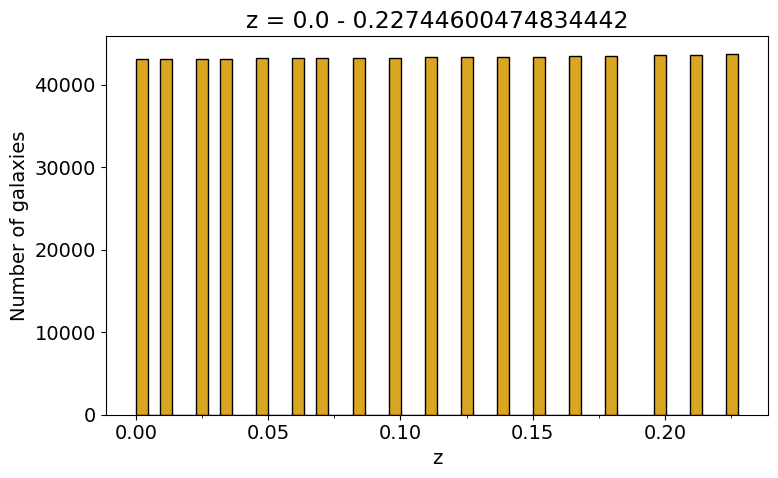

In [31]:
print('Min z:', min(z))
print('Max z:', max(z))

# z histogram
plt.figure(figsize=(8,5))
plt.hist(z, 50,
         edgecolor="black",
         facecolor="#daa520")
plt.xlabel(r"z")
plt.ylabel("Number of galaxies")
plt.title(f'z = {min(z)} - {max(z)}')
plt.tight_layout()

# set minor ticks every 0.025
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))

plt.show()

In [71]:
# Get mdot values in a given redshift interval

zmin, zmax = 0.15, 0.2
mdot_z = mdot[(z >= zmin) & (z <= zmax)]

nonzero_mdot = mdot_z[mdot_z > 0]

print('Total mdot values:', len(mdot_z))
print('Number of these that are not zero:', len(nonzero_mdot) )

print('Min:', min(nonzero_mdot))
print('Max:', max(nonzero_mdot))

Total mdot values: 173953
Number of these that are not zero: 7630
Min: 2.75062e-06
Max: 16.2607


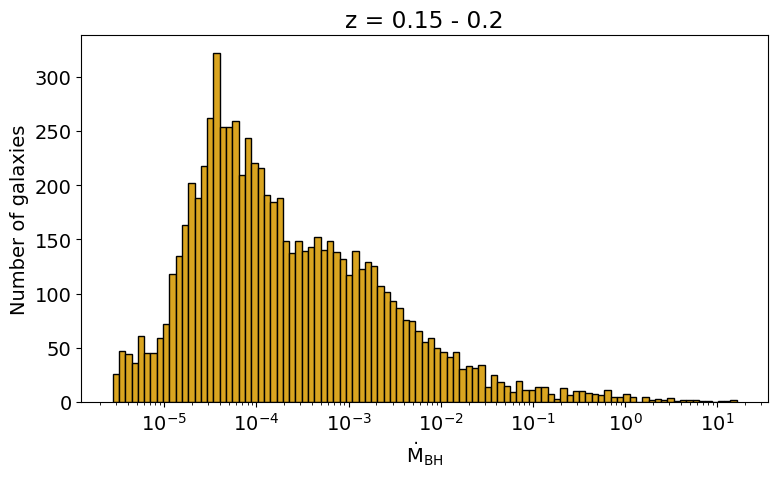

In [72]:
# --- Histogram with log-scaled x-axis ---
plt.figure(figsize=(8,5))
plt.hist(mdot_z, bins=np.logspace(np.log10(nonzero_mdot.min()),
                                           np.log10(nonzero_mdot.max()), 100),
         edgecolor="black",
         facecolor="#daa520")
plt.xscale("log")
plt.xlabel(r"$\rm \dot{M}_{BH}$")
plt.ylabel("Number of galaxies")
plt.title(f'z = {zmin} - {zmax}')
plt.tight_layout()
plt.show()

In [73]:
# nonzero_mdot varies from 1e-5 to 1e1

L_bol = 0.1 * (nonzero_mdot * 1.9891e33 / 3.154e+7) * (3e8)**2 # erg/s

# Boolean mask: True where finite, False where inf/-inf/NaN
mask = np.isfinite(L_bol)
L_bol = L_bol[mask]
nonzero_mdot = nonzero_mdot[mask]

print('After removing inf values:')
print(len(L_bol), 'values') 
print('L_bol range:', min(L_bol), '-', max(L_bol))
print('mdot range:', min(nonzero_mdot), '-', max(nonzero_mdot))


After removing inf values:
5300 values
L_bol range: 1.5612342e+36 - 3.400691e+38
mdot range: 2.75062e-06 - 0.000599142


/tmp/ipykernel_635942/27524946.py:3: RuntimeWarning: overflow encountered in multiply
  L_bol = 0.1 * (nonzero_mdot * 1.9891e33 / 3.154e+7) * (3e8)**2 # erg/s


Text(0.5, 0, '$\\rm \\dot{M}_{BH}$')

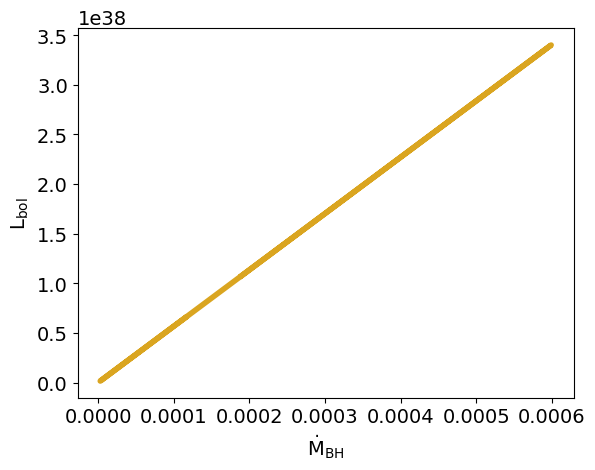

In [74]:
plt.plot(nonzero_mdot, L_bol, color='#daa520', lw=4)
plt.ylabel(r"$\rm L_{bol}$")
plt.xlabel(r"$\rm \dot{M}_{BH}$")

In [75]:
# Solar luminosity in ergs/s
L_sun = 3.828e33 

def bolometric_corrections(L_bol_array):
    """
    Calculates dispersed luminosities in different quasar bands
    from bolometric luminosities using Shen et al. (2020) corrections.
    
    Parameters
    ----------
    L_bol_array : array-like or float
        Bolometric luminosities in ergs/s.
    
    Returns
    -------
    dict
        Dictionary containing NumPy arrays for each band.
    """
    
    # float64 is needed since float32 wasn’t precise enough for the 
    # scale of the numbers
    L_bol_array = L_bol_array.astype(np.float64)
    
    log_L_bol = np.log10(L_bol_array)
    
    # Bolometric Correction Parameters
    params = {
        'B':  {'c1':3.759, 'k1':-0.361, 'c2':9.830, 'k2':-0.0063, 'sigma1':-0.383, 'sigma2':0.405, 'log_L0':42.39, 'sigma3':2.378},
        'UV': {'c1':1.862, 'k1':-0.361, 'c2':4.870, 'k2':-0.0063, 'sigma1':-0.372, 'sigma2':0.405, 'log_L0':42.31, 'sigma3':2.310},
        'Xsoft': {'c1':5.712, 'k1':-0.026, 'c2':17.67, 'k2':0.278, 'sigma1':0.080, 'sigma2':0.180, 'log_L0':44.16, 'sigma3':1.496},
        'Xhard': {'c1':4.073, 'k1':-0.026, 'c2':12.60, 'k2':0.278, 'sigma1':0.193, 'sigma2':0.066, 'log_L0':42.99, 'sigma3':1.883},
        'IR': {'c1':4.361, 'k1':-0.361, 'c2':11.40, 'k2':-0.0063, 'sigma1':-0.338, 'sigma2':0.407, 'log_L0':42.16, 'sigma3':2.193}
    }
    
    result = {}
    
    for band, p in params.items():
        # Mean luminosity
        denom = p['c1'] * (L_bol_array / (L_sun * 1e10))**p['k1'] + p['c2'] * (L_bol_array / (L_sun * 1e10))**p['k2']
        L_mean = L_bol_array / denom
        
        # Scatter
        scatter = ((p['sigma1'] + p['sigma2']) / 2 +
                   (p['sigma1'] - p['sigma2']) / 2 * erf((log_L_bol - p['log_L0']) / (np.sqrt(2) * p['sigma3'])))
        scatter = np.abs(scatter)  # ensure non-negative
        
        # Apply log-normal scatter
        L_disp = 10 ** np.random.normal(np.log10(L_mean), scatter)
        result[band] = L_disp
    
    return result

luminosities = bolometric_corrections(L_bol)
print(luminosities['B'])

[1.96866435e+35 1.33665289e+35 1.41429946e+35 ... 1.69632389e+35
 3.53311836e+35 7.09093214e+34]


In [76]:
def luminosity_function(band_luminosities, survey_volume, nbins=12, logL_range=None):
    """Compute luminosity function Phi(L) in Mpc^-3 dex^-1."""
    
    L = np.asarray(band_luminosities)

    # Default logL range
    if logL_range is None:
        logL_min = np.log10(L.min()) - 0.1
        logL_max = np.log10(L.max()) + 0.1
        logL_range = (logL_min, logL_max)

    logL_bins = np.linspace(logL_range[0], logL_range[1], nbins + 1)
    bin_centers = 0.5 * (logL_bins[:-1] + logL_bins[1:])

    counts, _ = np.histogram(np.log10(L), bins=logL_bins)
    counts = np.nan_to_num(counts, nan=0.0, posinf=0.0, neginf=0.0)

    bin_width = np.diff(logL_bins)[0]
    phi = counts / (survey_volume * bin_width)
    phi_err = np.sqrt(counts) / (survey_volume * bin_width)

    # Mask empty bins
    phi = np.where(counts > 0, phi, np.nan)
    phi_err = np.where(counts > 0, phi_err, np.nan)

    return bin_centers, phi, phi_err, counts


In [95]:
def plot_all_band_lfs(L_bol_array, survey_volume, nbins=12):
    """
    Plot luminosity functions in multiple bands from bolometric luminosities.
    
    Parameters
    ----------
    L_bol_array : array-like
        Array of bolometric luminosities in erg/s.
    survey_volume : float
        Volume of the survey in Mpc^3.
    nbins : int, optional
        Number of luminosity bins for the LF.
    """
    
    band_map = {
        "B-band": "B",
        "UV": "UV",
        "X-ray (soft)": "Xsoft",
        "X-ray (hard)": "Xhard",
        "IR": "IR",
    }

    band_colors = {
        "B-band": "#750202",
        "UV": "#a25016",
        "X-ray (soft)": "#daa520",
        "X-ray (hard)": "#556e37",
        "IR": "#116163",
    }

    # Get dispersed luminosities for all bands (vectorized)
    band_luminosities = bolometric_corrections(L_bol_array)

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, (band, key) in enumerate(band_map.items()):
        L_vals = band_luminosities[key]
        
        # Compute luminosity function (assumes this function is defined)
        logL_centers, phi, phi_err, counts = luminosity_function(L_vals, survey_volume, nbins=nbins)
        
        ax = axes[i]
        ax.plot(10**logL_centers, phi, color=band_colors[band], lw=4, ls='-')
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("L (erg/s)")
        ax.set_ylabel(r"$\Phi(L)$ [Mpc$^{-3}$ dex$^{-1}$]")
        ax.set_title(band)
        ax.set_ylim(bottom=1e-6)


    fig.suptitle(f"Redshift z = {zmin} - {zmax}", fontsize=18)
    
    # Hide extra subplot if needed
    axes[-1].axis("off")
    
    plt.tight_layout()
    plt.show()

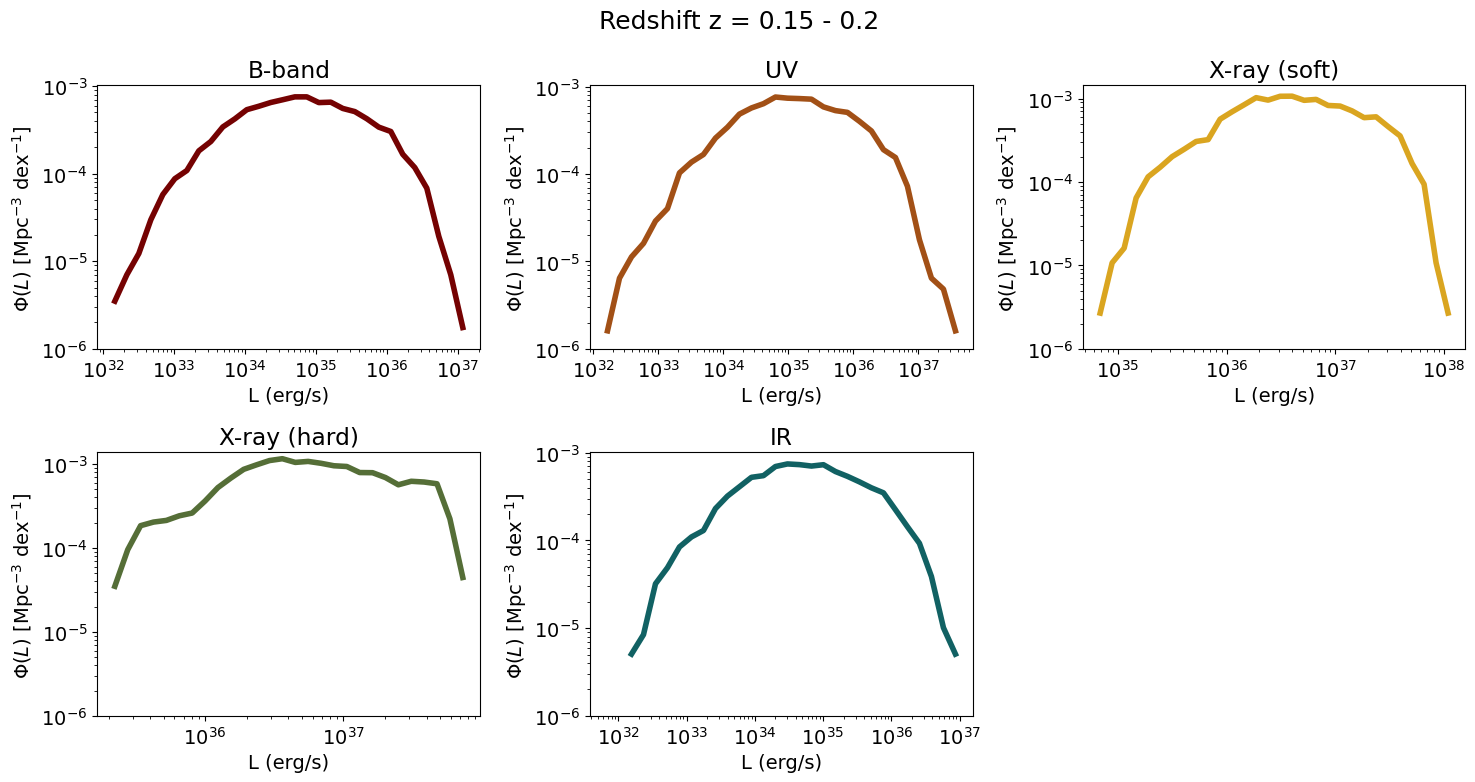

In [96]:
# This needs replacing with the actual volumes
vmax_array = np.full(len(L_bol), 100**3)

plot_all_band_lfs(L_bol, 150**3, nbins=30)